In [1]:
# some functions by me
import utils
import plotting

import numpy as np
import scipy as sp
import pandas as pd
import pycascades_solver
from tigramite import data_processing, plotting, pcmci
from tigramite.independence_tests import parcorr, robust_parcorr, gpdc, cmiknn
from tigramite.toymodels import structural_causal_processes as toys
import matplotlib.pyplot as plt
import pycascades_solver

In [2]:
def run_analysis(attributes, generator_fn=None, **kwargs):
    
    if generator_fn is None: return None

    pcmci_plus = kwargs["plus"] if "plus" in kwargs else True

    # generate data
    data, true, val_fn = generator_fn(attributes, **kwargs)
    
    # run PCMCI
    indpendence_test = kwargs["test"] if "test" in kwargs else robust_parcorr.RobustParCorr() 
    df  = data_processing.DataFrame(data, **utils.screen(data_processing.DataFrame, kwargs))
    res = pcmci.PCMCI(df, indpendence_test)

    if pcmci_plus:
        res = res.run_pcmciplus(**utils.screen(pcmci.PCMCI.run_pcmciplus, kwargs))
    else:
        res = res.run_pcmci(**utils.screen(pcmci.PCMCI.run_pcmci, kwargs))

    pred = res["graph"]
    
    am  = utils.accuracy_metrics(true, pred, **kwargs)
    ham = utils.hamming(true, pred, **kwargs)

    return (am["TPR"], am["FPR"], am["TNR"], am["FNR"], ham, true, pred)

In [3]:
global_params = dict(tau_min=0, tau_max=1, pc_alpha=0.05, discard_lags=False)

## Simple Onedirectional Coupling

In [4]:
# generator function

def identity(x):
    return x

def gen_simple_single(attributes, T=1000, **kwargs):

    # set up the links in the graph
    links = {
        0: [((0, -1), 0.95*0.5, identity)],
        1: [((1, -1), 0.95*0.5, identity),
            ((0, -1), attributes.coupling, identity)]
        }

    # generate the data 
    noises = [lambda T: np.random.normal(scale=attributes.internal_noise, size=T) for j in links.keys()]
    data, nonstationary = toys.structural_causal_process(links, T, noises)
    
    return data, toys.links_to_graph(links)

In [5]:
# run analysis
N = 1000
df_simple_single = pd.DataFrame()
df_simple_single["coupling"] = np.random.uniform(0, 2, N)
df_simple_single["internal_noise"] = 0.1
df_simple_single[["TPR", "FPR", "TNR", "FNR", "hamming"]] = df_simple_single.apply(
    run_analysis, axis=1, result_type="expand", generator_fn=gen_simple_single, discard_lags=True, **global_params)

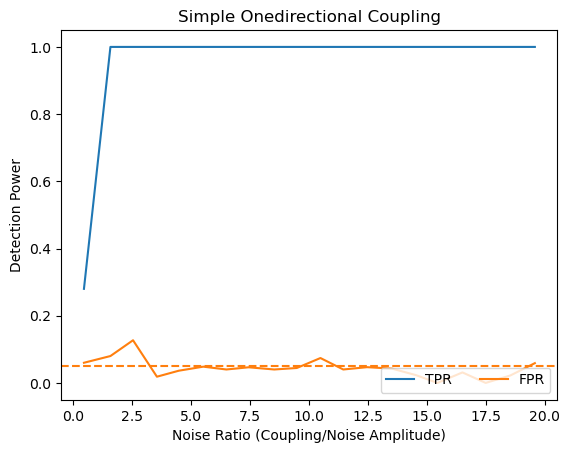

In [6]:
# plot results
df_plot = df_simple_single
df_plot["noise_ratio"] = df_plot.coupling/df_plot.internal_noise
df_plot = df_plot.groupby(pd.cut(df_plot.noise_ratio, 20)).mean()

plt.plot(df_plot.noise_ratio, df_plot.TPR, label="TPR")
plt.plot(df_plot.noise_ratio, df_plot.FPR, label="FPR")
plt.axhline(0.05, color="C1", ls="--")
plt.legend(loc="lower right", ncol=2)
plt.title("Simple Onedirectional Coupling")
plt.xlabel("Noise Ratio (Coupling/Noise Amplitude)")
plt.ylabel("Detection Power")
plt.show()

## Simple Feedback System

In [15]:
# generator function
def gen_simple_bidirectional(attributes, T=1000, **kwargs):

    # set up the links in the graph
    links = {
        0: [((0, -1), 0.95*0.5, identity),
            ((1,  0),  attributes.coupling, identity)],
        1: [((1, -1), 0.95*0.5, identity),
            ((0, -1), -attributes.coupling, identity)]
        }

    # generate the data 
    noises = [lambda T: np.random.normal(scale=attributes.internal_noise, size=T) for j in links.keys()]
    data, nonstationary = toys.structural_causal_process(links, T, noises)
    
    return data, toys.links_to_graph(links)

In [16]:
# run analysis
N = 1000
df_simple_bidirectional = pd.DataFrame()
df_simple_bidirectional["coupling"] = np.random.uniform(0, 1.4, N)
df_simple_bidirectional["internal_noise"] = 0.1
df_simple_bidirectional[["TPR", "FPR", "TNR", "FNR", "hamming"]] = df_simple_bidirectional.apply(
    run_analysis, axis=1, result_type="expand", generator_fn=gen_simple_bidirectional, discard_lags=False, **global_params)

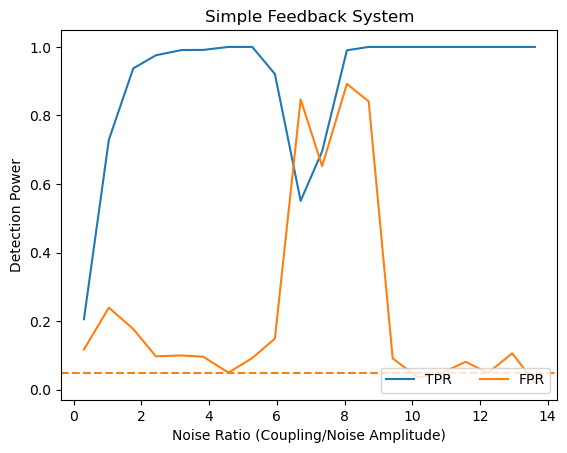

In [44]:
# plot results
df_plot = df_simple_bidirectional
df_plot["noise_ratio"] = df_plot.coupling/df_plot.internal_noise
df_plot = df_plot.groupby(pd.cut(df_plot.noise_ratio, 20)).mean()

plt.plot(df_plot.noise_ratio, df_plot.TPR, label="TPR")
plt.plot(df_plot.noise_ratio, df_plot.FPR, label="FPR")
plt.axhline(0.05, color="C1", ls="--")
plt.legend(loc="lower right", ncol=2)
plt.title("Simple Feedback System")
plt.xlabel("Noise Ratio (Coupling/Noise Amplitude)")
plt.ylabel("Detection Power")
plt.show()

## Tipping System 

In [4]:
# code to run the analysis on a tipping system

from matplotlib.gridspec import GridSpec

def run_tipping_analysis(coupling_matrix,
                         forcing = 0,
                         tau = None, 
                         coupling = np.linspace(0, 5, 500),
                         internal_noise = 0.1,
                         T = 1000,
                         plot = True,
                         **kwargs):

    kwargs = global_params | kwargs

    def gen_tipping(attributes, **kwargs):
        
        n = len(coupling_matrix)
        d = attributes.coupling * coupling_matrix

        y0 = "tipped" if "y0" not in kwargs else kwargs["y0"]

        # simulate tipping system
        data = pycascades_solver.solve(forcing, d, attributes.internal_noise, y0=y0, tspan=np.linspace(0, 110, T + 100), tau=tau)[100:]

        # construct links
        links = {i: [((j, -1), d[i, j], lambda x: x) for j in range(n) if d[i, j] != 0] for i in range(n)}

        val_matrix = np.zeros((n, n, kwargs["tau_max"] + 1))
        val_matrix[:,:,1] = d.T

        return data, toys.links_to_graph(links, tau_max=kwargs["tau_max"]), val_matrix

    # set up data frame
    df = pd.DataFrame()
    df["coupling"] = coupling
    df["internal_noise"] = internal_noise
    df["noise_ratio"] = df["coupling"]/df["internal_noise"]

    # run analysis
    df[["TPR", "FPR", "TNR", "FNR", "hamming", "true", "pred"]] = df.apply(run_analysis, axis=1, result_type="expand", generator_fn=gen_tipping, **kwargs)

    # plot results
    if plot:

        # aggregate results
        df_plot = df.copy()
        df_plot = df_plot.groupby(pd.cut(df_plot.noise_ratio, 20)).mean()

        # example simulation
        data, graph, val_matrix = gen_tipping(df.iloc[int(len(df)/2)], **kwargs)

        # example pcmci
        res = pcmci.PCMCI(data_processing.DataFrame(data), robust_parcorr.RobustParCorr())
        res = res.run_pcmciplus(**utils.screen(pcmci.PCMCI.run_pcmciplus, global_params))

        fig = plt.figure(figsize=(1.2*6, 1.2*4), layout="tight")
        gs  = GridSpec(2, 3, figure=fig)

        ax = fig.add_subplot(gs[0,2])
        plotting.plot_graph(graph, val_matrix/coupling.max(), show_colorbar=False, fig_ax=(fig, ax))
        ax.set_xlabel(f"Input\n(at {df.iloc[int(len(df)/2)].coupling:.2f} coupling)")
        ax.set_ylim(ax.get_xlim())
        ax.set_title("Causal Graphs")

        ax = fig.add_subplot(gs[1,2])
        plotting.plot_graph(res["graph"], res["val_matrix"], show_colorbar=False, fig_ax=(fig, ax))
        ax.set_xlabel("Output\nPCMCI+ / RobustParCorr")
        ax.set_ylim(ax.get_xlim())

        ax = fig.add_subplot(gs[0:2,0:2])
        ax.plot(df_plot.noise_ratio, df_plot.TPR, label="TPR", color="C0")
        ax.plot(df_plot.noise_ratio, df_plot.FPR, label="FPR", color="C1")
        ax.legend(loc="upper left")
        ax.axhline(global_params["pc_alpha"], color="C1", ls="--")
        ax.set_ylim([-0.05, 1.05])
        ax.set_title("Detection Power")
        ax.set_xlabel("Noise Ratio (Coupling/Noise Amplitude)")

    return df

### Binary Feedback

In [5]:
def bootstrap(arr, func=np.nanmean, n_resamples=None):
    n_resamples = len(arr) if n_resamples is None else n_resamples
    b = sp.stats.bootstrap((arr,), func, n_resamples=n_resamples, method="percentile")
    return b.confidence_interval.low, b.confidence_interval.high

In [6]:
def plot_TPR_FPR_cut(df, ax=None, N=25, kwargs_TPR = {}, kwargs_FPR = {}, **kwargs):
    
    # use new plot when no axis is given
    ax = ax if ax is not None else plt.gca()

    # cut and aggregate df for bootstrap CI
    df = df.groupby(pd.cut(df.noise_ratio, N))
    l, h = np.array([bootstrap(group.TPR) for key, group in df]).T
    
    df = df.mean()
    p, = ax.plot(df.noise_ratio, df.TPR, **(kwargs_TPR | kwargs))
    ax.plot(df.noise_ratio, df.FPR, **(dict(color=p._color, ls="dotted")| kwargs | kwargs_FPR))
    ax.fill_between(df.noise_ratio, l, h, **(dict(color=p._color, zorder=0, alpha=0.1) | kwargs | kwargs_TPR))
    return ax

def plot_TPR_FPR_rolling(df, ax=None, W=50, kwargs_TPR = {}, kwargs_FPR = {}, **kwargs):
    
    # use new plot when no axis is given
    ax = ax if ax is not None else plt.gca()

    # rolling window average
    df   = df.rolling(W, center=True)
    mean = df.mean()
    l, h = np.array([bootstrap(window.TPR) for window in df]).T
    
    # plot mean curves and confidence bands
    p, = ax.plot(mean.noise_ratio, mean.TPR, **(kwargs_TPR | kwargs))
    ax.plot(mean.noise_ratio, mean.FPR, **(dict(color=p._color, ls="dotted")| kwargs | kwargs_FPR))
    ax.fill_between(mean.noise_ratio, l, h, **(dict(color=p._color, zorder=0, alpha=0.1) | kwargs | kwargs_TPR))
    return ax


In [109]:
coupling_matrix = np.zeros((2, 2))
coupling_matrix[0,1] =  1.0
coupling_matrix[1,0] = -1.0

df_pcmciplus = run_tipping_analysis(coupling_matrix, plus=True,  plot=False, discard_lags=False, tau_max=5);
df_pcmci     = run_tipping_analysis(coupling_matrix, plus=False, plot=False, discard_lags=False, tau_max=5);

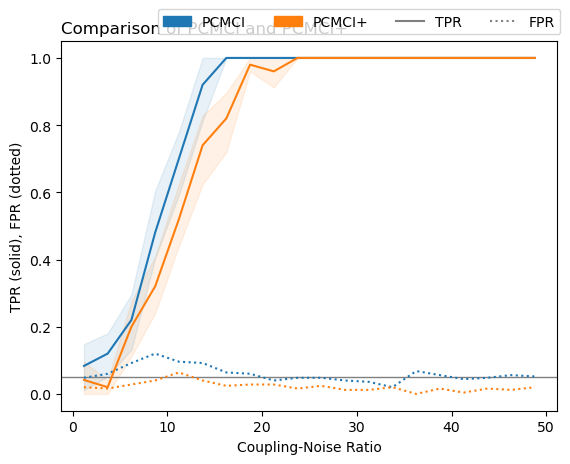

In [110]:
import matplotlib

ax = plt.gca()
plot_TPR_FPR_cut(df_pcmci, N=20)
plot_TPR_FPR_cut(df_pcmciplus, N=20)

handles = [matplotlib.patches.Patch(color="C0"),
           matplotlib.patches.Patch(color="C1"),
           matplotlib.lines.Line2D([], [], color="gray"),
           matplotlib.lines.Line2D([], [], color="gray", ls="dotted")]
plt.legend(handles=handles, labels=["PCMCI", "PCMCI+", "TPR", "FPR"], loc="lower right", bbox_to_anchor=(1.02, 1), ncols=4)

plt.axhline(0.05, c="gray", lw=1, zorder=0)
plt.xlabel("Coupling-Noise Ratio")
plt.ylabel("TPR (solid), FPR (dotted)")
plt.title("Comparison of PCMCI and PCMCI+", x=0, ha="left")
plt.show()

In [7]:
from earth_network_constants import random_couplings
import seaborn as sns
import pandas as pd

# get coupling constants
coupling_matrix = np.zeros((3, 3))
coupling_matrix[0,1] =  0.5
coupling_matrix[1,0] = -0.5
coupling_matrix[2,1] = -0.8
coupling_matrix[2,0] =  0.8
print(coupling_matrix)

# simulate network
# selection of seed is to find illustrative plot -> results are partly random
N  = coupling_matrix.shape[0]
ys = pycascades_solver.solve(0, coupling_matrix, 0.5, tspan=np.arange(0, 500, 0.1), generator=np.random.default_rng(seed=12))

sign = np.sign(ys)
smax = pd.DataFrame(sign).groupby(list(range(N))).size().idxmax()
mask = (sign == smax).all(axis=1)

[[ 0.   0.5  0. ]
 [-0.5  0.   0. ]
 [ 0.8 -0.8  0. ]]


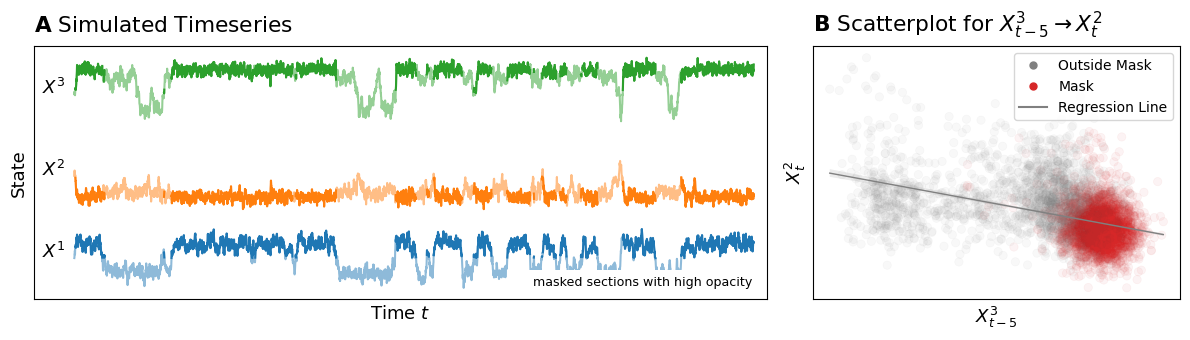

In [11]:
import matplotlib
import matplotlib.patches


fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), width_ratios=[2, 1])

ax = axs[0]
ax.set_title(r"$\bf{A}$ Simulated Timeseries", x=0, ha="left", pad=10)
for i, y in enumerate(ys.T):
    ax.plot(y + 5*i, alpha=0.5)
    ax.plot(np.ma.masked_where(~mask, y + 5*i), color=f"C{i}")
ax.set_xlim([-300, 5100])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"Time $t$")
ax.set_ylabel(r"State")
for i in range(3):
    ax.text(-150, 5*i, rf"$X^{i + 1}$", ha="center")
ax.text(0.98, 0.04, "masked sections with high opacity", ha="right", va="bottom", transform=ax.transAxes, size=7, bbox=dict(facecolor="white", edgecolor="none"))

ax = axs[1]
ax.set_title(r"$\bf{B}$ Scatterplot for $X^3_{t-5} \rightarrow X^2_t$", x=0, ha="left", pad=10)
x1, x2, x3 = ys.T
sns.scatterplot(x=pd.Series(x3).shift(-5), y=x2, hue=mask, palette=["gray", "C3"], alpha=0.05, ax=ax, edgecolor=None, legend=None)
sns.regplot(x=pd.Series(x3).shift(-5), y=x2, scatter=False, color="gray", line_kws=dict(lw=1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$X^3_{t - 5}$")
ax.set_ylabel(r"$X^2_t$")

handles = [
    matplotlib.lines.Line2D([], [], marker=".", linestyle="None", color="gray", markersize=10),
    matplotlib.lines.Line2D([], [], marker=".", linestyle="None", color="C3", markersize=10),
    matplotlib.lines.Line2D([], [], color="gray"),
]
ax.legend(handles, ["Outside Mask", "Mask", "Regression Line"])

plt.scale_font(1.3)
plt.tight_layout()
plt.savefig("../plots/nonstationarity_problem_A.png", dpi=200, bbox_inches="tight")
plt.show()

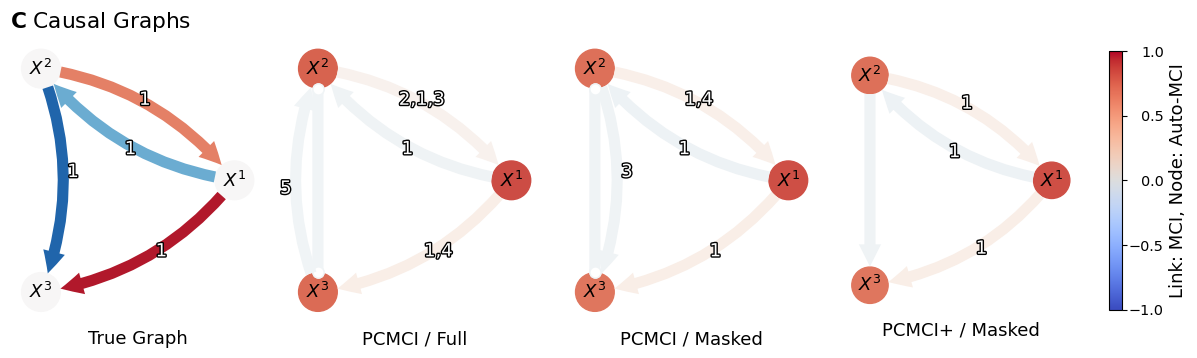

In [170]:
import matplotlib


fig, axs = plt.subplots(1, 4, figsize=(12, 3.5), width_ratios=[1, 1, 1, 1.1])

df        = data_processing.DataFrame(ys)
df_masked = data_processing.DataFrame(ys[mask])
var_names = [rf"$X^{i}$" for i in range(1, 4)]

ax = axs[0]
d = np.dstack([coupling_matrix.T, coupling_matrix.T])
d[:,:,0] = 0
plotting.plot_graph(graph=np.where(d != 0, "-->", ""), val_matrix=d, fig_ax=(fig, ax), show_colorbar=False, node_aspect=1, var_names=var_names)
ax.set_xlabel("True Graph")

# PCMCI - robustparcorr - full
res = pcmci.PCMCI(df, robust_parcorr.RobustParCorr())
res = res.run_pcmci(tau_max=5, pc_alpha=0.05)
ax = axs[1]
plotting.plot_graph(res["graph"], res["val_matrix"], fig_ax=(fig, ax), show_colorbar=False, node_aspect=1, var_names=var_names)
ax.set_xlabel("PCMCI / Full")

# PCMCI - robustparcorr - masked
res = pcmci.PCMCI(df_masked, robust_parcorr.RobustParCorr())
res = res.run_pcmci(tau_max=5, pc_alpha=0.05)
ax = axs[2]
plotting.plot_graph(res["graph"], res["val_matrix"], fig_ax=(fig, ax), show_colorbar=False, node_aspect=1, var_names=var_names)
ax.set_xlabel("PCMCI / Masked")

# PCMCI+ - robustparcorr - masked
res = pcmci.PCMCI(df_masked, robust_parcorr.RobustParCorr())
res = res.run_pcmciplus(tau_max=5, pc_alpha=0.05)
ax = axs[3]
plotting.plot_graph(res["graph"], res["val_matrix"], fig_ax=(fig, ax), show_colorbar=False, node_aspect=1, var_names=var_names)
ax.set_xlabel("PCMCI+ / Masked")

for ax in axs:
    ax.set_aspect(1)

norm = matplotlib.colors.Normalize(vmin=-1,vmax=1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ax=axs[-1], fraction=0.046, pad=0.1, ticks=[-1, -0.5, 0, 0.5, 1], label="Link: MCI, Node: Auto-MCI")

for t in cb.ax.get_yticklabels():
    t.set_horizontalalignment('right')
    t.set_fontsize(8)
    t.set_x(3.5)
# cb.ax.yaxis.set_label_position('left')

axs[0].set_title(r"$\bf{C}$ Causal Graphs", x=0, ha="left")
plt.scale_font(1.3)
plt.tight_layout()
plt.savefig("../plots/nonstationarity_problem_B.png", dpi=200, bbox_inches="tight")
plt.show()

In [42]:
coupling_matrix = np.zeros((3, 3))
coupling_matrix[0,1] =  0.5
coupling_matrix[1,0] = -0.5
coupling_matrix[2,1] =  0.8
coupling_matrix[2,0] =  0.8

# df_masked      = run_tipping_analysis(coupling_matrix, plus=False, plot=False, discard_lags=False, tau_max=5, coupling=np.linspace(0, 5, 500), internal_noise=0.1);
# df_masked_plus = run_tipping_analysis(coupling_matrix, plus=True,  plot=False, discard_lags=False, tau_max=5, coupling=np.linspace(0, 5, 500), internal_noise=0.1);
df_masked      = pd.read_csv("../data/df_masked.csv", index_col=0)
df_masked_plus = pd.read_csv("../data/df_masked_plus.csv", index_col=0)

# df_full      = run_tipping_analysis(coupling_matrix, plus=False, plot=False, discard_lags=False, tau_max=5, coupling=np.linspace(0, 5, 500), internal_noise=0.8, y0=0);
# df_full_plus = run_tipping_analysis(coupling_matrix, plus=True,  plot=False, discard_lags=False, tau_max=5, coupling=np.linspace(0, 5, 500), internal_noise=0.8, y0=0);
df_full      = pd.read_csv("../data/df_full.csv", index_col=0)
df_full_plus = pd.read_csv("../data/df_full_plus.csv", index_col=0)

In [36]:
for i, df in enumerate([df_masked, df_masked_plus, df_full, df_full_plus]):
    df.to_csv(f"../data/{['df_masked', 'df_masked_plus', 'df_full', 'df_full_plus'][i]}.csv")

In [34]:
def graph_iax(coupling_matrix, ax,loc=[0.45, 0.5-0.55/2, 0.55, 0.55], **kwargs):
    iax = ax.inset_axes(loc)
    iax.set_aspect(1)
    iax.set_facecolor("#00000000")
    plotting.plot_graph(*utils.coupling_to_graph(coupling_matrix), fig_ax=(fig, iax), node_aspect=1, var_names=var_names, show_colorbar=False, node_size=0.4, **kwargs)

    for child in iax._children:
        if isinstance(child, matplotlib.patches.FancyArrowPatch):
            child.set(mutation_scale=5)
        if isinstance(child, matplotlib.patches.Ellipse):
            child.set(color="#cccccc")

    return iax

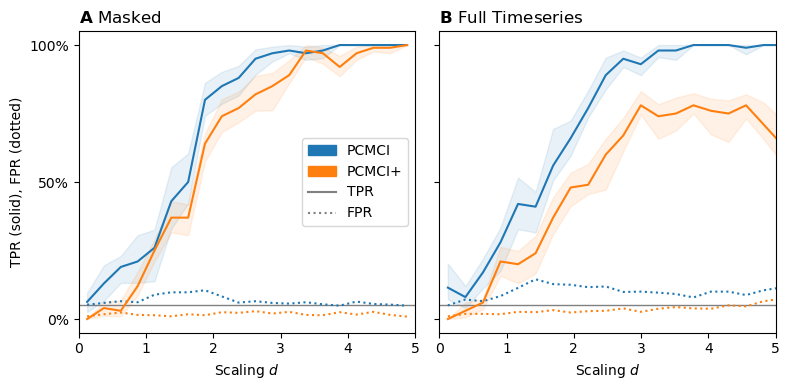

In [43]:
import matplotlib

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharey=True)

# masked timeseries
plot_TPR_FPR_cut(df_masked.iloc[:,:5], N=20, ax=axs[0])
plot_TPR_FPR_cut(df_masked_plus.iloc[:,:5], N=20, ax=axs[0])
axs[0].set_xticks(np.linspace(0, 50, 6), np.linspace(0, 5, 6, dtype="int"))
axs[0].set_yticks([0, 0.5, 1])
axs[0].set_xlim([0, 50])
axs[0].set_ylabel("TPR (solid), FPR (dotted)")
axs[0].yaxis.set_major_formatter("{x:.0%}")
axs[0].set_title(r"$\bf{A}$ Masked", ha="left", x=0)

# full timeseries
plot_TPR_FPR_cut(df_full.iloc[:,:5], N=20, ax=axs[1])
plot_TPR_FPR_cut(df_full_plus.iloc[:,:5], N=20, ax=axs[1])
axs[1].set_xticks(np.linspace(0, 6, 6), np.linspace(0, 5, 6, dtype="int"))
axs[1].set_xlim([0, 6])
axs[1].set_title(r"$\bf{B}$ Full Timeseries", ha="left", x=0)

for ax in axs:
    ax.axhline(0.05, c="gray", lw=1, zorder=0)
    ax.set_xlabel(r"Scaling $d$")

handles = [matplotlib.patches.Patch(color="C0"),
           matplotlib.patches.Patch(color="C1"),
           matplotlib.lines.Line2D([], [], color="gray"),
           matplotlib.lines.Line2D([], [], color="gray", ls="dotted")]
axs[0].legend(handles=handles, labels=["PCMCI", "PCMCI+", "TPR", "FPR"], loc="center right")


plt.tight_layout()
plt.savefig("../plots/masked_vs_full_detection_power.png", dpi=200, bbox_inches="tight")
plt.show()

### Simplified Feedback Systems

In [12]:
coupling_matrix_nico1 = np.zeros((3, 3))
coupling_matrix_nico1[1, 0] =  1.0
coupling_matrix_nico1[0, 1] = -1.0
coupling_matrix_nico1[2, 1] =  1.0

df_nico1 = pd.read_csv("../data/df_nico1.csv")
df_nico1_plus = pd.read_csv("../data/df_nico1_plus.csv")

# df_nico1      = run_tipping_analysis(coupling_matrix_nico1, plot=False, tau_max=5, plus=False);
# df_nico1_plus = run_tipping_analysis(coupling_matrix_nico1, plot=False, tau_max=5, plus=True);

In [13]:
coupling_matrix_nico2 = np.zeros((3, 3))
coupling_matrix_nico2[1, 0] =  1.0
coupling_matrix_nico2[0, 1] = -1.0
coupling_matrix_nico2[2, 1] =  1.0
coupling_matrix_nico2[2, 0] =  1.0

df_nico2 = pd.read_csv("../data/df_nico2.csv")
df_nico2_plus = pd.read_csv("../data/df_nico2_plus.csv")

# df_nico2      = run_tipping_analysis(coupling_matrix_nico2, plot=False, tau_max=5, plus=False);
# df_nico2_plus = run_tipping_analysis(coupling_matrix_nico2, plot=False, tau_max=5, plus=True);

In [14]:
coupling_matrix_nico3 = np.zeros((3, 3))
coupling_matrix_nico3[1, 0] =  1.0
coupling_matrix_nico3[0, 1] = -1.0
coupling_matrix_nico3[2, 1] =  1.0
coupling_matrix_nico3[1, 2] = -1.0
coupling_matrix_nico3[2, 0] =  1.0

df_nico3 = pd.read_csv("../data/df_nico3.csv")
df_nico3_plus = pd.read_csv("../data/df_nico3_plus.csv")

# df_nico3      = run_tipping_analysis(coupling_matrix_nico3, coupling=np.linspace(0, 10, 500), plot=False, tau_max=5, plus=False);
# df_nico3_plus = run_tipping_analysis(coupling_matrix_nico3, coupling=np.linspace(0, 10, 500), plot=False, tau_max=5, plus=True);

In [11]:
# for i, df in enumerate([df_nico1, df_nico1_plus, df_nico2, df_nico2_plus, df_nico3, df_nico3_plus]):
#     df.to_csv(f"../data/{['df_nico1', 'df_nico1_plus', 'df_nico2', 'df_nico2_plus', 'df_nico3', 'df_nico3_plus'][i]}.csv")

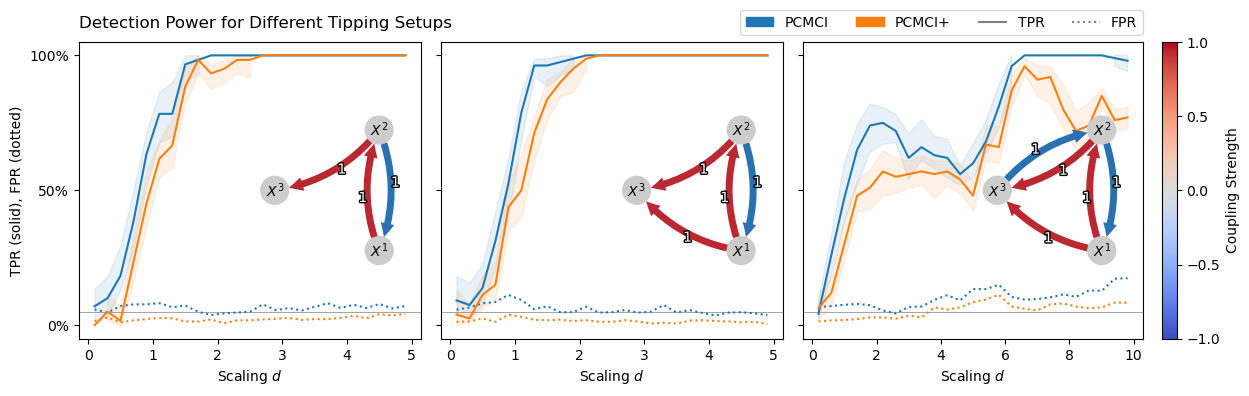

In [68]:
import matplotlib
import matplotlib.patches

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, width_ratios=[1, 1, 1.1])

var_names = [rf"$X^{i}$" for i in range(1, 4)]

t = -np.linspace(0, 2*np.pi, 4, endpoint=True) + np.pi - np.pi/6
node_pos = dict(x=np.sin(t), y=np.cos(t))

ax = axs[0]
plot_TPR_FPR_cut(df_nico1, ax=ax)
plot_TPR_FPR_cut(df_nico1_plus, ax=ax)
graph_iax(0.75*coupling_matrix_nico1, ax, node_pos=node_pos)

ax = axs[1]
plot_TPR_FPR_cut(df_nico2, ax=ax)
plot_TPR_FPR_cut(df_nico2_plus, ax=ax)
graph_iax(0.75*coupling_matrix_nico2, ax, node_pos=node_pos)

ax = axs[2]
plot_TPR_FPR_cut(df_nico3, ax=ax)
plot_TPR_FPR_cut(df_nico3_plus, ax=ax)
graph_iax(0.75*coupling_matrix_nico3, ax, node_pos=node_pos)

axs[0].set_yticks([0, 0.5, 1])
axs[0].yaxis.set_major_formatter("{x:>.0%}")
axs[0].set_title("Detection Power for Different Tipping Setups", ha="left", x=0, pad=10)
axs[0].set_ylabel("TPR (solid), FPR (dotted)")

for ax in axs:
    ax.set_xlabel(r"Scaling $d$")
    ax.axhline(0.05, lw=0.5, color="gray", zorder=0)
    ax.xaxis.set_major_formatter(lambda x, i: int(x/10))

plt.tight_layout()

handles = [matplotlib.patches.Patch(color="C0"),
           matplotlib.patches.Patch(color="C1"),
           matplotlib.lines.Line2D([], [], color="gray"),
           matplotlib.lines.Line2D([], [], color="gray", ls="dotted")]
plt.legend(handles=handles, labels=["PCMCI", "PCMCI+", "TPR", "FPR"], loc="lower right", bbox_to_anchor=(1.02, 1), ncols=4)

norm = matplotlib.colors.Normalize(vmin=-1,vmax=1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ax=axs[-1], fraction=0.046, pad=0.05, ticks=[-1, -0.5, 0, 0.5, 1], label=r"Coupling Strength")

plt.savefig("../plots/feedback_system_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

### Different Link Strengths

In [2]:
n_coupling = 50
n_runs = 200

coupling = np.linspace(0, 1, n_coupling)
coupling_matrices = np.zeros((n_coupling, 2, 2))
coupling_matrices[:, 1, 0] = coupling
coupling_matrices[:, 0, 1] = coupling - 1

coupling_mismatch = 2*coupling - 1

In [3]:
# res = [run_tipping_analysis(coupling_matrix, coupling=np.repeat([1, 3, 5], n_runs), plot=False) for coupling_matrix in coupling_matrices]
# res = pd.concat(res)
# res["coupling_mismatch"] = np.repeat(coupling_mismatch, 3*n_runs)
# res.to_csv("../data/asymmetric_feedback_detection_power.csv")
res = pd.read_csv("../data/asymmetric_feedback_detection_power.csv")

In [4]:
# bootstrap confidence interval of mean TPR
tpr_mean_conf = res.groupby(["coupling", "coupling_mismatch"]).TPR.apply(lambda g: sp.stats.bootstrap((g.to_numpy(),), np.nanmean, n_resamples=n_runs))

/usr/local/Caskroom/miniconda/base/envs/master-thesis/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/usr/local/Caskroom/miniconda/base/envs/master-thesis/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


In [5]:
def pc1_mci(coupling_matrix):
    y = pycascades_solver.solve(0, coupling_matrix, 0.1, "tipped")[100:]
    res = pcmci.PCMCI(data_processing.DataFrame(y), robust_parcorr.RobustParCorr())

    # PC1 stage 
    lagged_parents = res.run_pc_stable(link_assumptions=None, **global_params)
    val_pc1 = res.val_matrix.copy()

    # MCI stage
    mci_results = res._pcmciplus_mci_skeleton_phase(lagged_parents=lagged_parents,
                                      max_conds_dim=None,
                                      max_combinations=None,
                                      max_conds_py=None,
                                      max_conds_px=None,
                                      max_conds_px_lagged=None,
                                      fdr_method='none',
                                      reset_lagged_links=False,
                                      link_assumptions=res._set_link_assumptions(None, global_params["tau_min"], global_params["tau_max"]),
                                      p_matrix=res.p_matrix, val_matrix=res.val_matrix, **global_params)
    val_mci = mci_results["val_matrix"]

    return (val_pc1[0,1,1], val_pc1[1,0,1], val_mci[0,1,1], val_mci[1,0,1])

# val = np.array([[pc1_mci(5*coupling_matrix) for coupling_matrix in coupling_matrices] for i in range(n_runs)])
# np.save("../data/asymmetric_feedback_pc1_mci", val)
val = np.load("../data/asymmetric_feedback_pc1_mci.npy")

In [6]:
def bootstrap(arr, func=np.nanmean, n_resamples=n_runs):
    b = sp.stats.bootstrap((arr,), func, n_resamples=n_resamples)
    return b.confidence_interval.low, b.confidence_interval.high

def IQR(arr):
    return np.quantile(arr, 0.25), np.quantile(arr, 0.75)

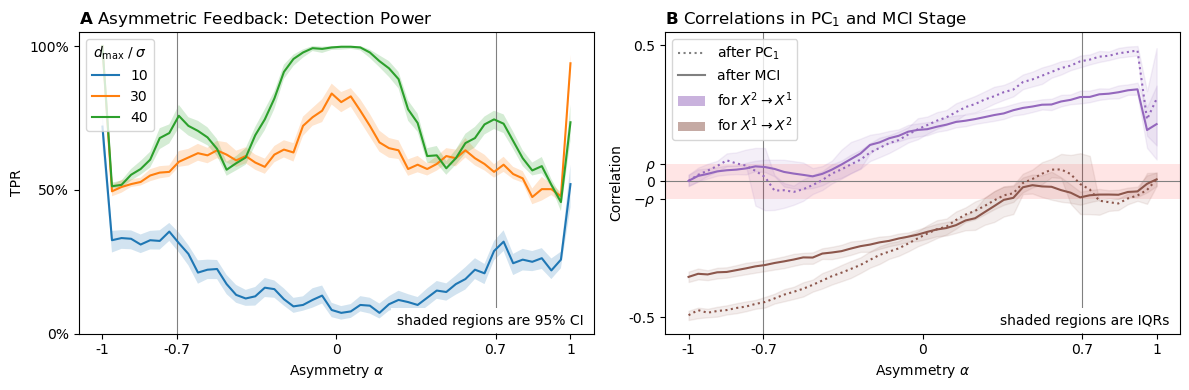

In [27]:
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Patch

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]

# confidence interval
for i, c in enumerate(tpr_mean_conf.index.unique(0)):
    ax.fill_between(tpr_mean_conf.index.unique(1), tpr_mean_conf[c].apply(lambda b: b.confidence_interval.low), tpr_mean_conf[c].apply(lambda b: b.confidence_interval.high), alpha=0.2, zorder=0)

# mean detection power
res.groupby(["coupling", "coupling_mismatch"]).mean().TPR.unstack("coupling").plot(ax=ax)

ax.set_title(r"$\bf{A}$ Asymmetric Feedback: Detection Power", x=0, ha="left")
ax.set_xlabel(r"Asymmetry $\alpha$")
ax.set_ylabel("TPR")
ax.set_xticks([-1, -0.68, 0, 0.68, 1], [-1, -0.7, 0, 0.7, 1])
ax.set_yticks([0, 0.5, 1.0])
[ax.axvline(x, c="gray", lw=0.8, zorder=0) for x in [-0.68, 0.68]]
ax.yaxis.set_major_formatter("{x:.0%}")
ax.legend(handles=[child for child in ax._children if isinstance(child, matplotlib.lines.Line2D)], labels=[10, 30, 40], title=r"$d_\text{max}\;/\;\sigma$", loc="upper left")
text = ax.text(0.98, 0.02, "shaded regions are 95% CI", ha="right", va="bottom", transform=ax.transAxes)
text.set_bbox(dict(facecolor="white", edgecolor="none"))

ax = axs[1]

# region in which links are rejected
ax.add_patch(Rectangle((-1.2, -0.065), 2.4, 2*0.065, facecolor="red", alpha=0.1))
ax.axhline(0, lw=0.8, c="gray")

# bootstrap significance estimates
b = np.apply_along_axis(IQR, 0, val[:,:,0])
plt.fill_between(coupling_mismatch, b[0], b[1], color="C4", alpha=0.1)
b = np.apply_along_axis(IQR, 0, val[:,:,1])
plt.fill_between(coupling_mismatch, b[0], b[1], color="C5", alpha=0.1)
b = np.apply_along_axis(IQR, 0, val[:,:,2])
plt.fill_between(coupling_mismatch, b[0], b[1], color="C4", alpha=0.1)
b = np.apply_along_axis(IQR, 0, val[:,:,3])
plt.fill_between(coupling_mismatch, b[0], b[1], color="C5", alpha=0.1)

# correlations after PC1 stage
ax.plot(coupling_mismatch, val.mean(axis=0)[:,0], c="C4", ls="dotted")
ax.plot(coupling_mismatch, val.mean(axis=0)[:,1], c="C5", ls="dotted")

# correlations after MCI stage
ax.plot(coupling_mismatch, val.mean(axis=0)[:,2], c="C4", ls="solid")
ax.plot(coupling_mismatch, val.mean(axis=0)[:,3], c="C5", ls="solid")

ax.set_title(r"$\bf{B}$ Correlations in PC$_1$ and MCI Stage", x=0, ha="left")
ax.set_xlabel(r"Asymmetry $\alpha$")
ax.set_ylabel("Correlation")
ax.set_yticks([-0.5, -0.065, 0, 0.065, 0.5], [-0.5, r"$-\rho$", 0, r"$\rho$", 0.5])
ax.set_xticks([-1, -0.68, 0, 0.68, 1], [-1, -0.7, 0, 0.7, 1])
ax.set_xlim([-1.1, 1.1])
[ax.axvline(x, c="gray", lw=0.8, zorder=0) for x in [-0.68, 0.68]]

legend_elements = [Line2D([0], [0], ls="dotted", color="gray"),
                   Line2D([0], [0], ls="solid", color="gray"),
                   Patch(facecolor='C4', alpha=0.5),
                   Patch(facecolor='C5', alpha=0.5)]
ax.legend(legend_elements, [r"after PC$_1$", "after MCI", r"for $X^2 \rightarrow X^1$", r"for $X^1 \rightarrow X^2$"])
text = ax.text(0.98, 0.02, "shaded regions are IQRs", ha="right", va="bottom", transform=ax.transAxes)
text.set_bbox(dict(facecolor="white", edgecolor="none"))

plt.tight_layout()
plt.savefig("../plots/asymmetric_feedback.png", dpi=200, bbox_inches="tight")
plt.show()

### Different Timescales

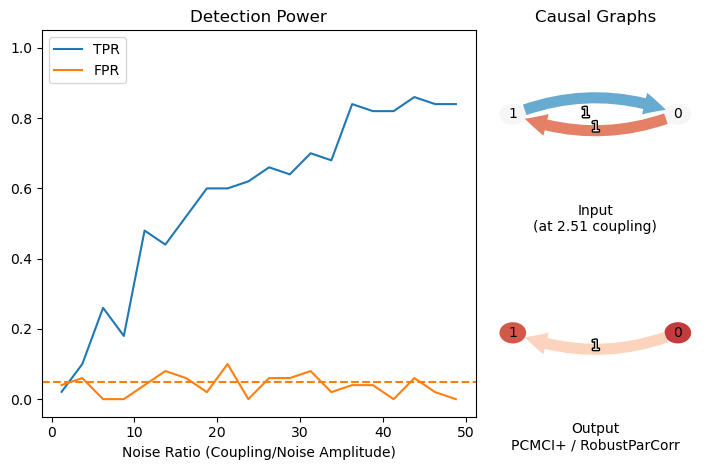

In [131]:
coupling_matrix = np.zeros((2, 2))
coupling_matrix[1, 0] =  1.0
coupling_matrix[0, 1] = -1.0
run_tipping_analysis(coupling_matrix, tau=np.array([5, 1]));

### Different Integration Step Size

In [163]:
coupling_matrix = np.zeros((2, 2))
coupling_matrix[1, 0] =  1.0
coupling_matrix[0, 1] = -0.6

T = np.linspace(180, 4000, 20, dtype="int")
n_runs = 100
res = [run_tipping_analysis(coupling_matrix, coupling=np.repeat(5.0, n_runs), T=t, plot=False) for t in T] 
res = pd.concat(res)
res["dt"] = np.repeat(110/(T + 100), n_runs)

(0.0, 1.0, 0.0, 1.0)

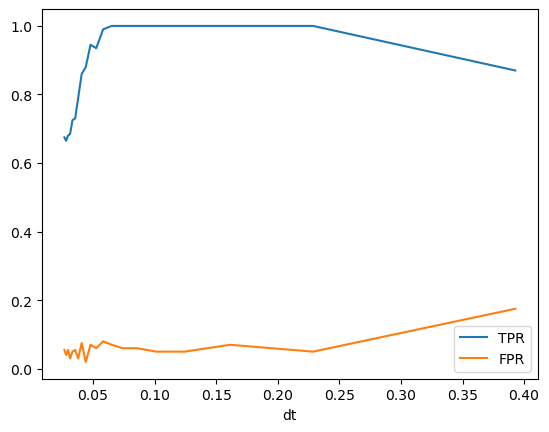

<Figure size 640x480 with 0 Axes>

In [ ]:
res.groupby("dt").mean().plot(y=["TPR", "FPR"])

#ax1 = plt.gca().inset_axes([0.05, 0.4, 0.2, 0.2], transform=plt.gca().transAxes)
#ax1.axis("off")
pycascades_solver.solve(0, coupling_matrix, tspan=np.linspace(0, 110, 180))

#ax2 = plt.gca().inset_axes([0.75, 0.4, 0.2, 0.2], transform=plt.gca().transAxes)
#ax2.axis("off")
plt.clf()

### Earth System

In [69]:
import earth_network_constants
Cmin, Cmax = earth_network_constants.S[:3,:3,0], earth_network_constants.S[:3,:3,1]
C = np.where(abs(Cmax) > abs(Cmin), Cmax, Cmin)
C

array([[ 0.  , -1.  ,  0.2 ],
       [ 1.  ,  0.  , -0.3 ],
       [ 1.  ,  0.15,  0.  ]])

In [70]:
C_pos = C.copy()
C_pos[1, 2] = 0.3
C_pos

array([[ 0.  , -1.  ,  0.2 ],
       [ 1.  ,  0.  ,  0.3 ],
       [ 1.  ,  0.15,  0.  ]])

In [71]:
C_neg = C.copy()
C_neg[1, 2] = -0.3
C_neg

array([[ 0.  , -1.  ,  0.2 ],
       [ 1.  ,  0.  , -0.3 ],
       [ 1.  ,  0.15,  0.  ]])

In [77]:
# df_pos      = run_tipping_analysis(C_pos, plot=False, discard_lags=False, tau_max=5, plus=False)
# df_pos_plus = run_tipping_analysis(C_pos, plot=False, discard_lags=False, tau_max=5, plus=True)
df_pos      = pd.read_csv("../data/df_pos.csv", index_col=0)
df_pos_plus = pd.read_csv("../data/df_pos_plus.csv", index_col=0)

In [78]:
# df_neg      = run_tipping_analysis(C_neg, plot=False, discard_lags=False, tau_max=5, plus=False)
# df_neg_plus = run_tipping_analysis(C_neg, plot=False, discard_lags=False, tau_max=5, plus=True)
df_neg      = pd.read_csv("../data/df_neg.csv", index_col=0)
df_neg_plus = pd.read_csv("../data/df_neg_plus.csv", index_col=0)

In [89]:
import re

In [102]:
# df_pos_link = run_tipping_analysis(C_pos, coupling=np.random.uniform(4, 5, 100), plot=False, discard_lags=False, tau_max=5, plus=False)
# df_neg_link = run_tipping_analysis(C_neg, coupling=np.random.uniform(4, 5, 100), plot=False, discard_lags=False, tau_max=5, plus=False)

def str2array(s):
    s = re.sub(r"(\\n)*\s+", ",", s)
    return np.array(eval(s))

df_pos_link = pd.read_csv("../data/df_pos_link.csv", index_col=0)
df_pos_link.true = df_pos_link.true.apply(str2array)
df_pos_link.pred = df_pos_link.pred.apply(str2array)
df_neg_link = pd.read_csv("../data/df_neg_link.csv", index_col=0)
df_neg_link.true = df_neg_link.true.apply(str2array)
df_neg_link.pred = df_neg_link.pred.apply(str2array)


In [75]:
# for i, df in enumerate([df_pos, df_pos_plus, df_neg, df_neg_plus, df_pos_link, df_neg_link]):
#     df.to_csv(f"../data/{['df_pos', 'df_pos_plus', 'df_neg', 'df_neg_plus', 'df_pos_link', 'df_neg_link'][i]}.csv")

In [103]:
from sklearn.metrics import confusion_matrix

def link_tpr(df, x, y, tau=1):

    true = df.true.apply(lambda G: G[x, y, tau] != "")
    pred = df.pred.apply(lambda G: G[x, y, tau] != "")

    tn, fp, fn, tp = confusion_matrix(true, pred, labels=[False, True]).ravel()
    tpr = tp/(tp + fn) if tp + fn != 0 else np.nan
    
    return tpr

res_pos = dict()
res_neg = dict()
for xy in np.ndindex((3, 3)):
    x, y = xy
    if x != y:
        res_pos[xy] = link_tpr(df_pos_link, x, y)
        res_neg[xy] = link_tpr(df_neg_link, x, y)
print(res_pos)
print(res_neg)

{(0, 1): 1.0, (0, 2): 1.0, (1, 0): 1.0, (1, 2): 0.39, (2, 0): 0.25, (2, 1): 0.96}
{(0, 1): 0.05, (0, 2): 1.0, (1, 0): 0.05, (1, 2): 0.17, (2, 0): 0.28, (2, 1): 0.11}


/var/folders/7l/yqf3zjyd3gg76r9wp6h3ltxr0000gn/T/ipykernel_29059/1364042443.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


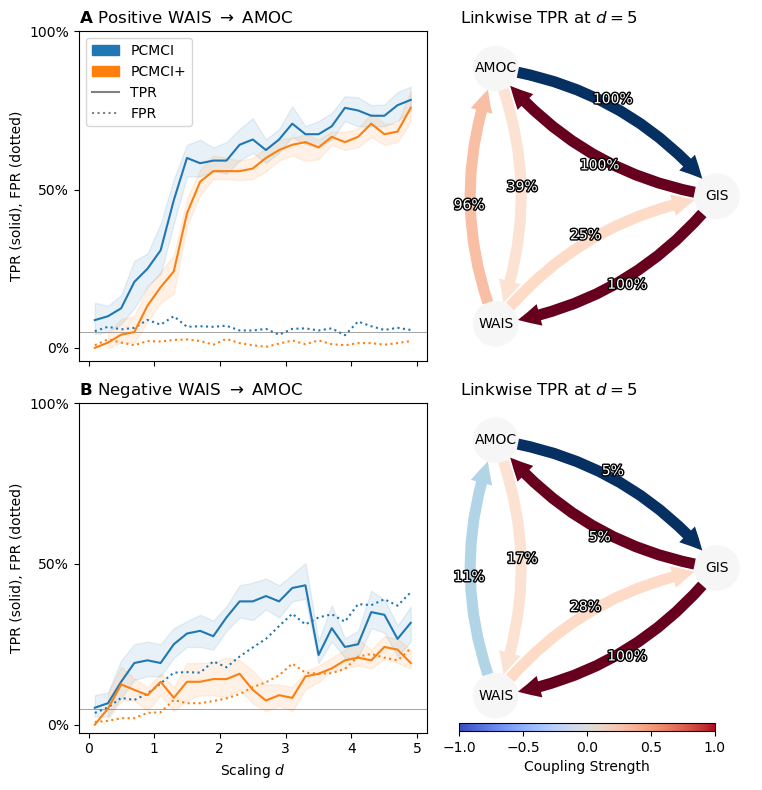

In [152]:
var_names   = ["GIS", "AMOC", "WAIS"]

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex="col")

ax = axs[0,0]
plot_TPR_FPR_cut(df_pos.iloc[:,:5], ax=ax)
plot_TPR_FPR_cut(df_pos_plus.iloc[:,:5], ax=ax)
ax.set_title(r"$\bf{A}$ Positive WAIS $\rightarrow$ AMOC", x=0, ha="left")

handles = [matplotlib.patches.Patch(color="C0"),
           matplotlib.patches.Patch(color="C1"),
           matplotlib.lines.Line2D([], [], color="gray"),
           matplotlib.lines.Line2D([], [], color="gray", ls="dotted")]
ax.legend(handles=handles, labels=["PCMCI", "PCMCI+", "TPR", "FPR"], loc="upper left")

ax = axs[1,0]
plot_TPR_FPR_cut(df_neg.iloc[:,:5], ax=ax)
plot_TPR_FPR_cut(df_neg_plus.iloc[:,:5], ax=ax)
ax.set_title(r"$\bf{B}$ Negative WAIS $\rightarrow$ AMOC", x=0, ha="left")
ax.set_xlabel(r"Scaling $d$")
ax.xaxis.set_major_formatter(lambda x, i: int(x/10))

for ax in axs[:,0]:
    ax.set_ylim([None, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.yaxis.set_major_formatter("{x:.0%}")
    ax.set_ylabel("TPR (solid), FPR (dotted)")
    ax.axhline(0.05, color="gray", lw=0.5, zorder=0)

ax = axs[0,1]
ax.set_aspect(1)
plotting.plot_graph(*utils.coupling_to_graph(C_pos), fig_ax=(fig, ax), show_colorbar=False, node_aspect=1, var_names=var_names)

idx = [(x, y) for x, y in np.ndindex((3, 3)) if x != y]
for i, text in enumerate([child for child in ax._children if isinstance(child, matplotlib.text.Text)][3:]):
    text.set(text=f"{res_pos[idx[i]]:.0%}")

ax = axs[1,1]
ax.set_aspect(1)
plotting.plot_graph(*utils.coupling_to_graph(C_neg), fig_ax=(fig, ax), show_colorbar=False, node_aspect=1, var_names=var_names)

for i, text in enumerate([child for child in ax._children if isinstance(child, matplotlib.text.Text)][3:]):
    text.set(text=f"{res_neg[idx[i]]:.0%}")

for ax in axs[:,1]:
    ax.set_title(r"Linkwise TPR at $d=5$", ha="left", x=0)

norm = matplotlib.colors.Normalize(vmin=-1,vmax=1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
# ax = fig.add_axes([0.75-0.125, 0.52, 0.25, 0.02])
# cb = fig.colorbar(sm, cax=ax, fraction=0.042, pad=0, ticks=[-1, -0.5, 0, 0.5, 1], label=r"Coupling Strength", location="bottom")
ax = fig.add_axes([0.58, 0.08, 0.32, 0.01])
cb = fig.colorbar(sm, cax=ax, fraction=0.042, pad=0, ticks=[-1, -0.5, 0, 0.5, 1], label=r"Coupling Strength", location="bottom")
# ax = fig.add_axes([0.85, 0.5-0.125, 0.02, 0.25])
# cb = fig.colorbar(sm, cax=ax, fraction=0.042, pad=0, ticks=[-1, -0.5, 0, 0.5, 1], label=r"Coupling Strength", location="right")


plt.tight_layout()
plt.savefig("../plots/detection_power_earth_system.png", dpi=200, bbox_inches="tight")
plt.show()

In [180]:
import matplotlib

def angle_to_element(a):
    if abs(a) < np.pi/2:
        return 0
    else:
        return 1 if a > 0 else 2

for child in ax._children:
    if isinstance(child, matplotlib.patches.FancyArrowPatch):
        (xf, yf), (xt, yt) = child._posA_posB
        f = np.arctan2(yf, xf).round(2) # angle in radians between [-pi, pi]
        t = np.arctan2(yt, xt).round(2)
        f = angle_to_element(f)
        t = angle_to_element(t)
        print(rf"{var_names[f]} $\rightarrow$ {var_names[t]}")
            

GIS $\rightarrow$ AMOC
GIS $\rightarrow$ AMOC
GIS $\rightarrow$ WAIS
GIS $\rightarrow$ WAIS
AMOC $\rightarrow$ GIS
AMOC $\rightarrow$ GIS
AMOC $\rightarrow$ WAIS
AMOC $\rightarrow$ WAIS
WAIS $\rightarrow$ GIS
WAIS $\rightarrow$ GIS
WAIS $\rightarrow$ AMOC
WAIS $\rightarrow$ AMOC
